In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [328]:
plt.rcParams["font.size"] = 16

In [329]:
df=pd.read_csv('madisontem_10.csv')
df1=df.copy()
df1


,STATION,DATE,DEWP,FRSHTT,MAX,MIN,PRCP,STP,TEMP,VISIB,WDSP
0,72641014837,2010-01-01,1.4,0,28.0,-0.9,0.00,992.6,8.8,10.0,5.3
1,72641014837,2010-01-02,-4.8,0,15.1,-5.1,0.00,998.1,3.3,10.0,7.0
2,72641014837,2010-01-03,-6.0,1000,12.0,-8.0,0.00,999.5,1.3,9.7,5.2
3,72641014837,2010-01-04,2.0,0,17.1,-8.0,0.00,995.8,8.3,10.0,6.0
4,72641014837,2010-01-05,5.3,0,19.0,1.0,0.00,992.1,12.9,9.9,6.1
...,...,...,...,...,...,...,...,...,...,...,...
3647,72641014837,2019-12-27,26.8,0,48.9,28.0,0.00,989.3,33.7,9.9,5.8
3648,72641014837,2019-12-28,25.4,11000,37.9,21.0,0.00,988.9,29.3,6.0,4.1
3649,72641014837,2019-12-29,44.0,10000,54.0,21.2,0.90,971.9,47.1,6.7,8.8
3650,72641014837,2019-12-30,32.4,11000,54.0,30.0,0.37,964.8,36.6,9.1,6.2


In [330]:
df1["Rain"]=df1["PRCP"].isin([0])==False

In [331]:
df1[["DATE"]] = df1[["DATE"]].apply(pd.to_datetime)
df1["Month"]=df1["DATE"].dt.month

Text(0.5, 0.98, 'Figure 1b: Monthly: Number of times precipitations')

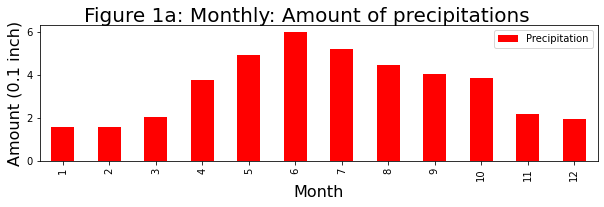

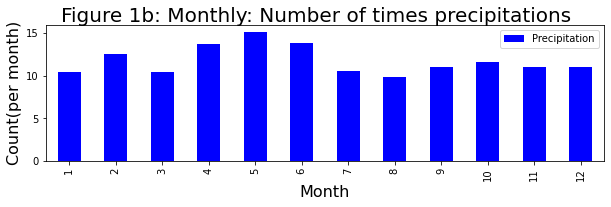

In [332]:
df_month=pd.DataFrame(df1.groupby("Month")["PRCP"].sum())/10
df_month1=pd.DataFrame(df1.groupby("Month")["Rain"].sum(True))/10

fig1, ax1 = plt.subplots(figsize=(10 ,2.5))
df_month.plot(ax=ax1,kind='bar',color="red", fontsize=10)
ax1.set_ylabel("Amount (0.1 inch)")
ax1.legend(["Precipitation"],fontsize=10)
fig1.suptitle("Figure 1a: Monthly: Amount of precipitations ", fontsize=20)
fig2, ax2 = plt.subplots( figsize=(10 ,2.5))
df_month1.plot(ax=ax2,kind='bar',color="blue", fontsize=10,ylabel="Count(per month)")
ax2.legend(["Precipitation"],fontsize=10)
fig2.suptitle("Figure 1b: Monthly: Number of times precipitations", fontsize=20)

In [373]:
col=["DEWP","MAX","MIN","STP","TEMP","WDSP"]
ycol="Rain"

1    0.807526
2    0.982344
3    0.999525
4    0.999725
5    0.999893
6    1.000000
dtype: float64
1    0.503400
2    0.673635
3    0.836190
4    0.990480
5    0.995603
6    1.000000
dtype: float64


Text(0.5, 1.0, 'Figure 2: Principal Components of Breaks')

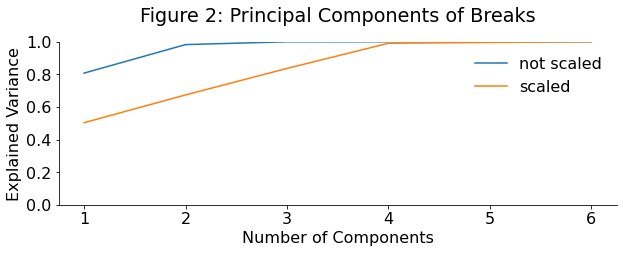

In [379]:
def explained(scale):
    stages = [("imp", SimpleImputer(strategy="most_frequent"))]
    if scale:
        stages.append(("std", StandardScaler()))
    stages.append(("pca", PCA()))
    p = Pipeline(stages)
    p.fit(df1[col])
    explained = p["pca"].explained_variance_ratio_
    s = pd.Series(explained.cumsum() / explained.sum(),
                  index=range(1, len(col)+1))
    s.sort_index(inplace=True)
    print(s)
    return s
plt = explained(False).plot.line(label="not scaled",figsize=(10 ,3),ylim=(0,1))
explained(True).plot.line(label="scaled", ax=plt)
plt.set_xlabel("Number of Components")
plt.set_ylabel("Explained Variance")
plt.spines["top"].set_visible(False)
plt.spines["right"].set_visible(False)
plt.legend(frameon=False)
plt.set_title("Figure 2: Principal Components of Breaks", pad=20)

In [375]:
train, test = train_test_split(df1, stratify=df1["Rain"], random_state=0)
train.shape, test.shape


((2739, 13), (913, 13))

In [376]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
def do_eval(balanced=None):
    p = Pipeline([
        ("std", StandardScaler()),
        ("lr", LogisticRegression()),
    ])
    p.fit(train[col], train[ycol])
    print("Score", p.score(test[col], test[ycol]))
    print("Recall", recall_score(test[ycol], p.predict(test[col])))
    print("Precision", precision_score(test[ycol], p.predict(test[col])))
    print(confusion_matrix(test[ycol], p.predict(test[col])) / len(test) * 100)
    
    return p
p = do_eval()


Score 0.7393209200438116
Recall 0.559322033898305
Precision 0.7071428571428572
[[52.24534502  8.98138007]
 [17.08652793 21.68674699]]


Text(0.5, 1.0, 'Figure 3: Logistic Regression Coefficients')

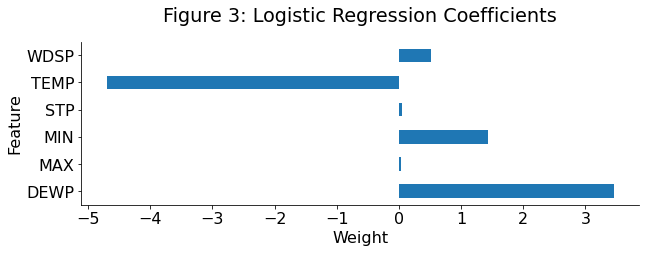

In [377]:
idx = [t.replace("_", " ") for t in col]
plt = pd.Series(p["lr"].coef_[0], index=idx).plot.barh(figsize=(10 ,3))
plt.set_xlabel("Weight")
plt.set_ylabel("Feature")
plt.spines["top"].set_visible(False)
plt.spines["right"].set_visible(False)
plt.set_title("Figure 3: Logistic Regression Coefficients", pad=20)